# [E-08] 자동 텍스트 요약 인공지능 만들기

### 라이브러리 import

In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print('라이브러리 import 및 NLTK 패키지에서 불용어 사전 다운로드 완료')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


라이브러리 import 및 NLTK 패키지에서 불용어 사전 다운로드 완료


# 2. 데이터 전처리

### 데이터 다운로드 및 불러오기

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

### 데이터 살펴보기

In [3]:
data.sample(10)

,headlines,text
962,"MS Dhoni, Virat Kohli ride Segway on ground af...",Former India captain MS Dhoni and current capt...
96941,'Cheap Thrills' singer Sia spotted without her...,"Singer Sia, known for songs like 'Cheap Thrill..."
10729,Reason behind demonetisation still a mystery: ...,Delhi CM Arvind Kejriwal on Thursday questione...
24340,Police summon ex-Gujarat BJP Vice President in...,Surat Police has issued summons to former Guja...
38416,I'm not political: Apple CEO on running for US...,On being asked if he would consider running fo...
58935,"Player scores over 1,000 Ranji runs in 4 match...",Karnataka opener Mayank Agarwal has hit over 1...
45925,Kerala withdraws case against MLAs who vandali...,Kerala's CPI (M) government has withdrawn a ca...
51396,"OnePlus confirms 40,000 users' credit card dat...",Smartphone maker OnePlus has admitted that cre...
7431,"1 researcher killed, 3 injured in explosion at...",Researcher Manoj K was killed and three others...
26994,Chhattisgarh CM defeats no-confidence motion a...,Chhattisgarh Chief Minister Raman Singh-led BJ...


### 학습에 사용할 데이터만 뽑아 재출력

In [4]:
data = data[['headlines','text']]
data.head()

#랜덤한 15개 샘플 출력
data.sample(1)

,headlines,text
66498,UFC champion defends title for record-breaking...,American mixed martial artist Demetrious Johns...


### 중복 데이터를 제외한 데이터 확인

In [5]:
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98360
text 열에서 중복을 배제한 유일한 샘플의 수 : 98280


### 중복 데이터 제거

In [6]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)
data.drop_duplicates(subset = ['headlines'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98262


### 결측치 확인

In [7]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


### 동일 의미를 지닌 텍스트의 정규화 처리를 위한 텍스트 정규화 사전 불러오기

In [8]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


### 학습에 도움이 되지 않는 불용어를 NLTK에서 제공하는 불용어 리스트를 참조하여 제거하기

In [9]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

### 공백, 특수문자, html 태그 제거 등 텍스트 정리 함수 작성

In [10]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
print('=3')

=3


### 작성한 함수가 잘 작동하는지 확인

In [11]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_headlines = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("headlines:", preprocess_sentence(temp_headlines, False))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
headlines: great way to start the day


### 완성된 함수로 훈련데이터 전체에 대해 전처리 진행

In [12]:
clean_text = []
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("text 전처리 후 결과: ", clean_text[:5])

text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

### Headlines에서의 불용어 제거 제외

In [13]:
clean_headlines = []
# 전체 Headlines 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

print("Headlines 전처리 후 결과: ", clean_headlines[:5])

Headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


### 빈 샘플이 생겼는지 재확인하기 위해 데이터를 데이터 프레임에 저장

In [14]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

### 재확인

In [15]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

### Summary 내 새로생긴 70개의 결측치 제거

In [16]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98262


### 샘플의 최대 길이 정하기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.10029309397326
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299444342675704


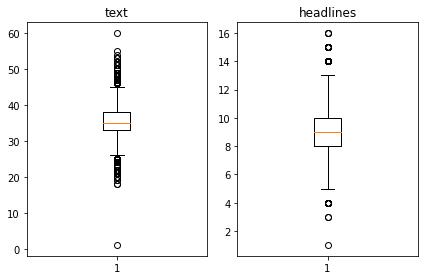

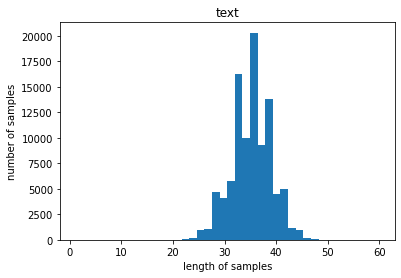

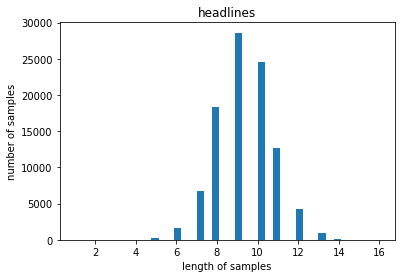

In [17]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

### 적절한 길이를 임의로 정하고 해당 데이터의 분포 비율을 확인하기 

In [37]:
text_max_len = 38
headlines_max_len = 10
print('=3')

=3


### 비율 계산 함수 작성

In [38]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
print('=3')

=3


### 비율 확인

In [39]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 38 이하인 샘플의 비율: 0.816317599886019
전체 샘플 중 길이가 10 이하인 샘플의 비율: 0.816317599886019


### 정해진 길이보다 긴 데이터는 제외시켜서 데이터 정제

In [40]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 65231


### 시작 토큰과 종료 토큰 추가

In [41]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
9,cong wins ramgarh bypoll in rajasthan takes to...,congress candidate shafia zubair ramgarh assem...,sostoken cong wins ramgarh bypoll in rajasthan...,cong wins ramgarh bypoll in rajasthan takes to...
10,up cousins fed human excreta for friendship wi...,two minor cousins uttar pradesh gorakhpur alle...,sostoken up cousins fed human excreta for frie...,up cousins fed human excreta for friendship wi...


### 인코더, 디코더의 입력과 레이블을 Numpy 타입으로 저장

In [43]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
print('encoder_input, decoder_input, decoder_target => Numpy array로 저장 완료')

encoder_input, decoder_input, decoder_target => Numpy array로 저장 완료


### 훈련, 테스트 데이터셋 분리를 위한 정수 시퀀스 만들기

In [44]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[ 5452 56672 58854 ... 53676 61999 32150]


### 만들어진 정수 시퀀스를 이용해 샘플의 순서 재정의

In [45]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print('=3')

=3


### 데이터셋 분리

In [46]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 13046


### 전체 데이터 양분

In [47]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 52185
훈련 레이블의 개수 : 52185
테스트 데이터의 개수 : 13046
테스트 레이블의 개수 : 13046


### 정수 인코딩
기계가 텍스트를 숫자로 인식할 수 있도록 텍스트 데이터를 정수로 전환한다. 이를 위해서는 각 단어에 고유한 정수를 맵핑하는 작업이 필요하고 이를 단어 집합을 만든다고 표현한다. 여기서 정제된 훈련 데이터를 단어 집합으로 만들어 본다. 

### Keras의 토크나이저를 사용하여 단어집합으로 만들기 

In [48]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print('=3')

=3


단어집합이 생성됨과 동시에 각 단어에 고유한 정수가 부여되었다. 생성된 단어 집합은 src_tokenizer.word_index에 저장되어 있다.

### 등장 빈도수가 낮은 단어들을 훈련 데이터에서 제외하기 위해 통계 정보 확인

In [49]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 57225
등장 빈도가 6번 이하인 희귀 단어의 수: 39334
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 17891
단어 집합에서 희귀 단어의 비율: 68.73569244211446
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.529202036200629


### 등장 빈도가 6회 이하인 단어는 정수 인코딩 과정에서 제외하고 훈련 데이터에서 제거

In [50]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('=3')

=3


In [51]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[12, 5048, 4120, 862, 1202, 71, 932, 427, 222, 2539, 405, 130, 3942, 1, 7, 2, 14, 35, 213, 116, 416, 82, 593, 226, 737, 3645, 848, 7, 5728, 130], [35, 6673, 627, 2656, 2581, 1635, 538, 769, 164, 77, 673, 937, 4270, 3003, 126, 102, 63, 2124, 3303, 487, 3813, 1, 538, 1604, 476, 363, 3107, 2581, 2609, 5250, 3943], [3646, 36, 788, 8, 1403, 425, 426, 427, 429, 20, 1736, 442, 2241, 3873, 65, 21, 213, 849, 91, 4457, 426, 3077, 4356, 3573, 884, 20, 772, 903, 533, 68]]


### Summary 데이터도 동일한 작업 수행

In [52]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
print('=3')

=3


In [53]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 25861
등장 빈도가 5번 이하인 희귀 단어의 수: 17482
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8379
단어 집합에서 희귀 단어의 비율: 67.59986079424615
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.520505304054251


In [54]:
tar_vocab = 2000 # 단어 집합의 크기를 어림잡아 2,000으로 제한
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 78, 1296, 8, 98, 129, 5, 125], [1, 19, 441, 367, 97, 1822, 6, 1451], [1, 374, 98, 568, 103, 4, 179], [1, 142, 105, 93, 320, 115, 28], [1, 41, 3, 321, 17, 729, 21]]
target
decoder  [[78, 1296, 8, 98, 129, 5, 125, 2], [19, 441, 367, 97, 1822, 6, 1451, 2], [374, 98, 568, 103, 4, 179, 2], [142, 105, 93, 320, 115, 28, 2], [41, 3, 321, 17, 729, 21, 2]]


다음 과정으로 넘어가기 전에 한가지 점검할 것이 있다. 전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플이 텅 빈 샘플이 되었을 가능성이 있다. 원문의 경우 길이가 상대적으로 길었기에 크게 문제가 없겠지만 Summary의 경우엔 이 현상이 두드려졌을 가능성이 높으므로 확인해 보고 삭제하여야 한다. 

### Headlines에서 길이가 0이 된 샘플들의 인덱스 받아오기

In [55]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 9
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 52176
훈련 레이블의 개수 : 52176
테스트 데이터의 개수 : 13046
테스트 레이블의 개수 : 13046


길이가 0이 된 요약문의 실제 길이는 시작, 종료 토큰이 들어가있으므로 1로 표시가 된다. 따라서 길이가 1인 Summary는 학습에 도움되지 않는 데이터이므로 삭제시켜 준다. 

### 샘플들의 길이를 맞추기 위해 패딩 작업하기 

In [57]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')
print('=3')

=3


길었던 데이터 전처리의 과정이 끝났고 이제 학습을 진행할 모델을 설계한다. 

## 3. 모델 설계

### 함수형 API를 이용하여 인코더 설계하기 

In [58]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128 # 임베딩 벡터의 차원
hidden_size = 256 # LSTM에서 가지는 수용력 / LSTM에서의 뉴런의 개수

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

### 디코더 설계

In [59]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

인코더와 거의 동일하게 디코더를 설계하지만 디코더의 경우 인자값으로 hidden state와 cell state의 값을 넣어줘야 한다. 

### 디코더의 출력층 설계 

In [60]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 38)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 38, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 38, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

여기서 그대로 모델을 사용해도 좋지만 디코더의 출력층 설계를 살짝 바꿔서 더욱 성능을 높일 수 있도록 어텐션 메커니즘을 이용한다. 

### 어텐션 층을 만들고 디코더 출력층 수정하기

In [61]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 38)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 38, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 38, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

## 4. 모델 학습

In [62]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
204/204 [==============================] - 124s 524ms/step - loss: 4.4778 - val_loss: 4.1521
Epoch 2/50
204/204 [==============================] - 106s 518ms/step - loss: 4.0661 - val_loss: 3.8877
Epoch 3/50
204/204 [==============================] - 105s 513ms/step - loss: 3.7982 - val_loss: 3.6543
Epoch 4/50
204/204 [==============================] - 104s 512ms/step - loss: 3.5759 - val_loss: 3.4911
Epoch 5/50
204/204 [==============================] - 104s 511ms/step - loss: 3.4146 - val_loss: 3.3760
Epoch 6/50
204/204 [==============================] - 104s 509ms/step - loss: 3.2754 - val_loss: 3.2745
Epoch 7/50
204/204 [==============================] - 104s 511ms/step - loss: 3.1583 - val_loss: 3.1922
Epoch 8/50
204/204 [==============================] - 104s 510ms/step - loss: 3.0546 - val_loss: 3.1208
Epoch 9/50
204/204 [==============================] - 104s 510ms/step - loss: 2.9645 - val_loss: 3.0729
Epoch 10/50
204/204 [==============================] - 103s 506m

val_loss가 줄어들지 않고 증가하는 현상이 2회 관찰되면 학습이 멈추도록 설정되어 있다. 따라서 학습이 멈춘 지금 시점에서 W값이 최적점이라 할 수 있다. 이 과정을 시각화해서 확인해본다. 

### 훈련 데이터와 검증 데이터의 손실치 시각화하여 확인

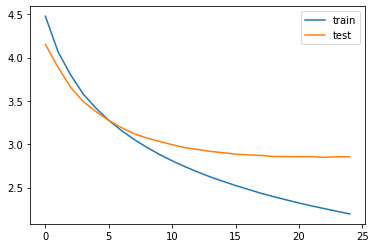

In [63]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 5. 모델 테스트 준비

### 인퍼런스 모델 구현하기
테스트 단계에서는 실제로 텍스트를 구현해야 하기때문에 정수로 존재하는 행렬 데이터를 다시 텍스트 데이터로 복원해야 한다. 이를 위해 필요한 3개의 단어 사전을 미리 준비한다. 

In [64]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

print('=3')

=3


### 인코더와 디코더 모델을 분리하여 인퍼런스 설계
학습에 사용한 seq2seq 모델은 훈련할 때와 실제 동작할때(인퍼런스 단계)의 방식이 다르므로 모델 설계를 별개로 진행해야 한다. 따라서 인코더 모델과 디코더 모델을 분리하여 설계한다. 

In [65]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

print('=3')

=3


### 어텐션 메커니즘을 사용하는 출력층 설계

In [66]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('=3')

=3


### 단어 시퀀스를 완성하는 함수 제작

In [70]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
print('=3')

=3


## 6. 모델 성능 평가
정수 시퀀스를 텍스트 시퀀스로 변환하여 결과를 확인한다. 

### 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수 작성

In [71]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

print('=3')

=3


### 테스트 샘플 출력

In [72]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : reacting indian wicketkeeper rishabh pant instagram video seen performing indian spinner chahal commented apollo se offer hai seen video responding comment year old delhi cricketer wrote yes joining 
실제 요약 : offer hai on 
예측 요약 :  video shows india dancing viral video goes viral


원문 : microsoft ceo satya nadella recent event called technology companies protect users data said us treat privacy human right talking cyber threats nadella also said companies use power protect common citizens small businesses speaking microsoft future conference london 
실제 요약 : we need to as human right microsoft ceo 
예측 요약 :  microsoft ceo to use of microsoft


원문 : egyptian court saturday sentenced death members banned muslim group anti government protests concluded mass trial people took part sit organised support former president mohamed people reportedly killed security forces crackdown protests 
실제 요약 : muslim members sentenced to death in egypt 
예측 요약 :  muslim muslim muslim body to muslim


원문 

## 7. 추출적 요약 시도

앞선 모델을 통해 텍스트 요약의 방법 중 하나인 추상적 요약을 진행해 보았다. 이번에는 추상적 요약이 아닌 추출적 요약을 시도하여 성능을 테스트한다. 

## 8. 데이터 다운 

In [73]:
import requests
from summa.summarizer import summarize

In [74]:
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text

In [75]:
print('### 데이터를 일부 확인합니다 ###')
print(text[:1500])

### 데이터를 일부 확인합니다 ###
The screen is filled with green, cascading code which gives way to the title, The Matrix.

A phone rings and text appears on the screen: "Call trans opt: received. 2-19-98 13:24:18 REC: Log>" As a conversation takes place between Trinity (Carrie-Anne Moss) and Cypher (Joe Pantoliano), two free humans, a table of random green numbers are being scanned and individual numbers selected, creating a series of digits not unlike an ordinary phone number, as if a code is being deciphered or a call is being traced.

Trinity discusses some unknown person. Cypher taunts Trinity, suggesting she enjoys watching him. Trinity counters that "Morpheus (Laurence Fishburne) says he may be 'the One'," just as the sound of a number being selected alerts Trinity that someone may be tracing their call. She ends the call.

Armed policemen move down a darkened, decrepit hallway in the Heart O' the City Hotel, their flashlight beam bouncing just ahead of them. They come to room 303, kick do

### summarize 사용하기

# 후기

아쉽게도 시간부족으로 summarize까지 시도해보지 못하고 후기도 제대로 작성하지 못했다. 
어려운 부분이 많았는데 학습시간이 너무 오래걸려 충분히 여러가지 시도해보지 못한 점이 아쉬웠다. 